# Test ML Pipeline

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import findspark
findspark.init()

In [4]:
import pyspark

In [5]:
cd ..

/Users/cls/Documents/IndependentDataScience/Projects/Telekom/pyspark-ml-pipeline-factory


In [6]:
from mlpipelinefactory import factory

In [7]:
data_path = "/Users/cls/Documents/IndependentDataScience/Projects/point8/data-science-101/notebooks/.assets/data/titanic/titanic.csv"

In [8]:
spark = pyspark.sql.SparkSession \
    .builder \
    .appName("MLPipelineTest") \
    .getOrCreate()


In [9]:
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType

schema = StructType([
             StructField('PassengerId', StringType()),
             StructField('Survived', IntegerType()),
             StructField('Pclass', IntegerType()),
             StructField('Name', StringType()),
             StructField('Sex', StringType()),
             StructField('Age', IntegerType()),
             StructField('SibSp', IntegerType()),
             StructField('Parch', IntegerType()),
             StructField('Ticket', StringType()),
             StructField('Fare', DoubleType()),
             StructField('Cabin', StringType()),
             StructField('Embarked', StringType())
        ])

In [10]:
data = spark.read.format("csv").option("header", "true").schema(schema).load(data_path) 


In [12]:
data.show(5)

+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex|Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male| 22|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female| 38|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female| 26|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female| 35|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male| 35|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+---+-----+-----+---------------

In [13]:
data.dtypes

[('PassengerId', 'string'),
 ('Survived', 'int'),
 ('Pclass', 'int'),
 ('Name', 'string'),
 ('Sex', 'string'),
 ('Age', 'int'),
 ('SibSp', 'int'),
 ('Parch', 'int'),
 ('Ticket', 'string'),
 ('Fare', 'double'),
 ('Cabin', 'string'),
 ('Embarked', 'string')]

In [14]:
pf = factory.MLPipelineFactory(data=data,
                                    problemType="classification",
                                    target="Survived",
                                    numericCols=[
                                            "Age",
                                            "Fare",
                                            "SibSp",
                                            "Parch"
                                        ],
                                    categoricalCols = [
                                            "Sex",
                                            "Embarked"
                                        ],
                                    categoricalEncoding="index",
                                    algorithm="Random Forest")


In [15]:
pf.make()

assembling feature vectors, using input columns:  ['Age', 'Fare', 'SibSp', 'Parch', 'Sex_indexed', 'Embarked_indexed']


In [16]:
splitRatio = 0.8
training, test = data.randomSplit([splitRatio, 1-splitRatio])

In [17]:
%%time
pipeline = pf.getPipeline("complete")
model = pipeline.fit(training)



CPU times: user 46.6 ms, sys: 9.44 ms, total: 56 ms
Wall time: 4.91 s


In [18]:
test.show()

+-----------+--------+------+--------------------+------+----+-----+-----+------------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|            Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+------------------+-------+-----+--------+
|       null|    null|  null|                null|  null|null| null| null|              null|   null| null|    null|
|       null|    null|  null|                null|  null|null| null| null|              null|   null| null|    null|
|       null|    null|  null|                null|  null|null| null| null|              null|   null| null|    null|
|         10|       1|     2|Nasser, Mrs. Nich...|female|  14|    1|    0|            237736|30.0708| null|       C|
|        102|       0|     3|"Petroff, Mr. Pas...|  male|null|    0|    0|            349215| 7.8958| null|       S|
|        106|       0|     3|Mionoff, Mr. Stoy...|  male|  28|  

In [19]:
predictions = model.transform(test)


In [20]:
print(predictions.dtypes)

[('features', 'vector'), ('label', 'int'), ('rawPrediction', 'vector'), ('probability', 'vector'), ('prediction', 'double')]


In [21]:
predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[14.0,30.0708,1.0...|    1|[5.96862768854396...|[0.29843138442719...|       1.0|
|(6,[0,1],[28.0,7....|    0|[16.6164131936464...|[0.83082065968232...|       0.0|
|(6,[0,1],[22.0,8....|    0|[17.3427054084352...|[0.86713527042176...|       0.0|
|[17.0,14.4583,0.0...|    0|[3.48107379175352...|[0.17405368958767...|       1.0|
|[12.0,11.2417,1.0...|    1|[17.519031921949,...|[0.87595159609744...|       0.0|
|(6,[0,1],[20.0,7....|    0|[17.8673856162598...|[0.89336928081299...|       0.0|
|[23.0,15.0458,0.0...|    0|[15.4720054890006...|[0.77360027445003...|       0.0|
|[24.0,79.2,0.0,0....|    0|[10.4317973712807...|[0.52158986856403...|       0.0|
|[19.0,6.75,0.0,0....|    0|[16.7369450085493...|[0.83684725042746...|       0.0|
|(6,[0,1],[35.0,

In [22]:
factory.evaluateClassifier(pf, data)

,label,Precision,Recall,F1
0,0.0,0.941860,0.771429,0.848168
1,1.0,0.657143,0.901961,0.760331


In [23]:
importances = factory.computeFeatureImportances(pf, data)

In [24]:
importances

Sex_indexed         0.513377
Fare                0.215395
Age                 0.124691
SibSp               0.064442
Parch               0.047725
Embarked_indexed    0.034371
dtype: float64

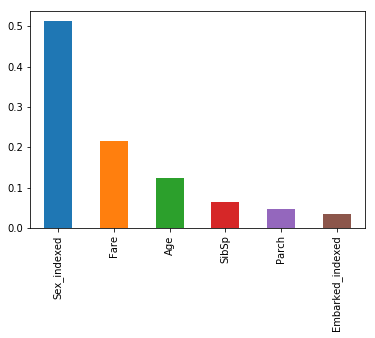

In [25]:
importances.plot(kind="bar")